<a href="https://colab.research.google.com/github/AvishneelNarayan/ADS2002-anar0025/blob/main/Overfit_and_underfit_MPG%20solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overfitting and underfitting with TensorFlow

Previously, when we introduced `sklearn` we investigated the effect of *overfitting* and *underfitting* on a dataset for [predicting the onset of Diabetes](https://gitlab.erc.monash.edu.au/bads/data-challenges-resources/-/blob/main/Machine-Learning/Supervised-Methods/Regression/01-ML_Workflow_Diabetes.ipynb?ref_type=heads). This is also known as obtaining a balance between *bias*, where the model is too simple, and *variance*, where the model is too complex. In this notebook we will investigate the same problem using the fuel efficiency dataset, but with our model being a TensorFlow Sequential Neural Network.

In [predicting fuel efficiency](https://gitlab.erc.monash.edu.au/bads/data-challenges-resources/-/blob/main/Machine-Learning/Neural%20Networks/NN_Regression_MPG_2024.ipynb?ref_type=heads) we saw that the accuracy of models on the validation data would peak after training for a number of epochs and then stagnate or start decreasing.

In other words, the model would *overfit* to the training data. Learning how to deal with overfitting is important. Although it is often possible to achieve high accuracy on the *training set*, what you really want is to develop models that generalize well to a *testing set* (data they haven't seen before).

The opposite of overfitting is *underfitting*. Underfitting occurs when there is still room for improvement on the training data. This can happen for a number of reasons: If the model is not powerful enough, is over-regularized, or has simply not been trained long enough. This means the network has not learned the relevant patterns in the training data.

If you train for too long though, the model will start to overfit and learn patterns from the training data that don't generalize to the test data. You need to strike a balance. Understanding how to train for an appropriate number of epochs as you'll explore below is a useful skill.

To prevent overfitting, the best solution is to use more complete training data. The dataset should cover the full range of inputs that the model is expected to handle. Additional data may only be useful if it covers new and interesting cases.

A model trained on more complete data will naturally generalize better. When that is no longer possible, the next best solution is to use techniques like regularization. These place constraints on the quantity and type of information your model can store.  If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well.

In this notebook, you'll explore several common regularization techniques, and use them to improve on a regression model.

## Contents

* Imports
* The MPG dataset
* Overfitting and Underfitting
* Strategies to Prevent Overfitting
* Conclusions
* Exercises

## Imports

Before getting started, we import the necessary packages:

In [1]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

We will use TensorFlow Docs to plot the data and provide a helpful callback routine.

In [30]:
# if tensorflow_docs cannot be found, uncomment the following line
#!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

The following routines are used for setting up the Feed-Forward Neural Network and for setting up regularization later in the notebook.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Normalization, Dropout
from tensorflow.keras.optimizers import SGD

Import routines for undertaking standard Data Science and plotting tasks.

In [4]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

## The MPG dataset

The MPG dataset is a good set for explaining overfitting and underfitting as:
* It is small, therefore we do not need particularly complex models to experience overfitting.
* Some of the features have high correlation, which will also cause overfitting.

The import and processing of the MPG data set follows the same process as in the introduction to using neural networks for regression problems.

We do the following:
* Read in the data from the UCI ML archive and add column names.
* Drop rows with missing data.
* Convert the origin from categories to regions.
* Convert the *Origin* column to binary columns for each region.

In [5]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

df = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

df.dropna(inplace=True)

df['Origin'] = df['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

df = pd.get_dummies(df, columns=['Origin'], prefix='', prefix_sep='', dtype=int)

Next we split the data into features and labels, and into a training and validation set. We will not create a testing set, as we just want to focus on the training process.

In [6]:
features = df.drop(['MPG'], axis=1)
labels = df['MPG']

X_train, X_val, y_train, y_val = train_test_split(features, labels,
                                                    test_size=0.2,
                                                    random_state=42)

Finally, we create a normalization layer so that the features have similar distributions. This is good practise for all machine learning, but it is particularly important when using L1 (lasso) and L2 (ridge) regularization to ensure that the weights are treated uniformly.

In [7]:
normalizer = Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

## Demonstrate overfitting

The simplest way to prevent overfitting is to start with a small model: A model with a small number of learnable parameters (which is determined by the number of layers and the number of nodes per layer). In deep learning, the number of learnable parameters in a model is often referred to as the model's "capacity".

Intuitively, a model with more parameters will have more "memorization capacity" and therefore will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any generalization power, which would be useless when making predictions on previously unseen data.

Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge is generalization, not fitting.

On the other hand, if the network has limited memorization resources, it will not be able to learn the mapping as easily. To minimize its loss, it will have to learn compressed representations that have more predictive power. At the same time, if you make your model too small, it will have difficulty fitting to the training data. There is a balance between "too much capacity" and "not enough capacity". This is another way to describe the balance between *variance* and *bias*.

Unfortunately, there is no magical formula to determine the right size or architecture of your model (in terms of the number of layers, or the right size for each layer). You will have to experiment using a series of different architectures.

To find an appropriate model size, it is best to start with relatively few layers and parameters, then begin increasing the size of the layers or adding new layers until you see diminishing returns on the validation loss.

Start with a simple model using only densely-connected layers as a baseline, then create larger models, and compare them.

### Training procedure

Each model in this notebook will use the same training configuration. So set these up in a reusable way, starting with the list of callbacks.

The training for this tutorial runs for many short epochs. To reduce the logging noise use the `tfdocs.EpochDots` which simply prints a `.` for each epoch, and a full set of metrics every 20 epochs. This can be changed by changing the parameter `report_every`.

Next include `tf.keras.callbacks.EarlyStopping` to avoid long and unnecessary training times. This callback is set to monitor the `val_loss`, since we are considering a regression problem. We set `patience=20`, which means that if the validation loss does not improve over 20 epochs, then the training stops.

In [8]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(report_every=20),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto',
                                     patience=20, restore_best_weights=True),
  ]

Similarly each model will use the same `Model.compile` and `Model.fit` settings:

In [9]:
def compile_and_fit(model, name, optimizer=None, max_epochs=1000):
  if optimizer is None:
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
  model.compile(optimizer=optimizer, loss='mean_absolute_error')

  model.summary()

  history = model.fit(
    X_train, y_train,
    epochs=max_epochs,
    validation_data=(X_val, y_val),
    callbacks=get_callbacks(name),
    verbose=0)
  return history

### Tiny model

We start by training a model a simple model as a baseline, which has one hidden layer and 16 nodes in this layer.

In [10]:
tiny_model = Sequential()
tiny_model.add(normalizer)
tiny_model.add(Dense(16, activation="relu"))
tiny_model.add(Dense(1))

Set up a structure for storing the training histories.

In [11]:
size_histories = {}

Now compile and train the tiny model, and store the history.

In [12]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (313, 9)                    │              19 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)


Epoch: 0, loss:22.9793,  val_loss:21.7695,  
....................
Epoch: 20, loss:3.7803,  val_loss:3.6249,  
....................
Epoch: 40, loss:2.3105,  val_loss:2.3171,  
....................
Epoch: 60, loss:1.9760,  val_loss:1.8857,  
....................
Epoch: 80, loss:1.9137,  val_loss:1.7761,  
....................

Now check how the model did. It can be seen that the training loss decreases smoothly, but the validation loss plateaus and the simulation is stopped after approximately 60 epochs, as this is not improving any further. After this overfitting of the model occurs.

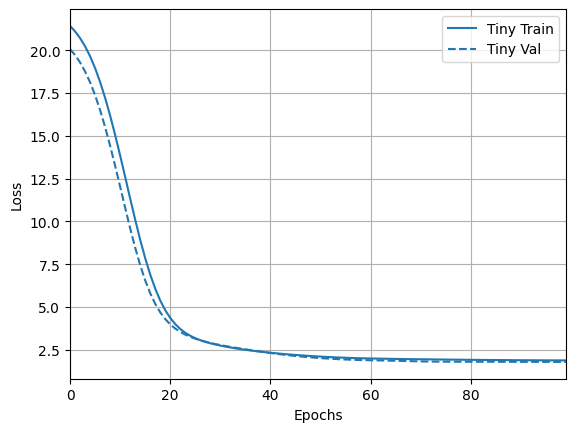

In [13]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter.plot(size_histories)

### Small model

To check if we can beat the performance of the tiny model, we progressively train some larger models.

First, try two hidden layers with 16 nodes in each.

In [14]:
small_model = Sequential()
small_model.add(normalizer)
small_model.add(Dense(16, activation="relu"))
small_model.add(Dense(16, activation="relu"))
small_model.add(Dense(1))

In [15]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (None, 9)                   │              19 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)


Epoch: 0, loss:23.5448,  val_loss:22.5802,  
....................
Epoch: 20, loss:2.2079,  val_loss:2.1401,  
....................
Epoch: 40, loss:1.9014,  val_loss:1.7918,  
....................
Epoch: 60, loss:1.8150,  val_loss:1.6922,  
....................
Epoch: 80, loss:1.8551,  val_loss:1.6662,  
............

From this point we will only plot the validation loss in the range 0 to 5, for easier comparison of the models. The small model has greater learning capacity that the tiny model, so it trains in less epochs, although the time for each epoch will be longer. The extra layer in this case appears to be beneficial in reducing the validation loss.

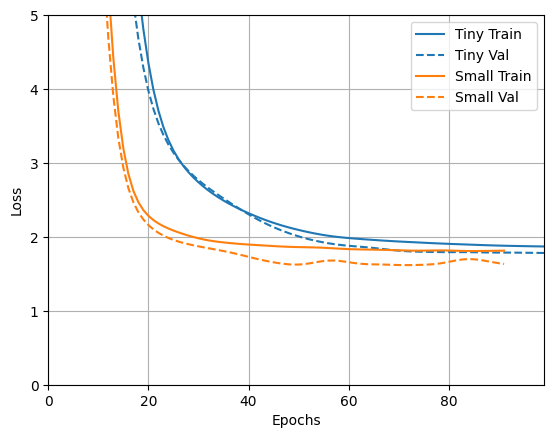

In [16]:
plotter.plot(size_histories)
plt.ylim([0,5]);

### Medium model

We now try three hidden layers with 64 nodes in each.

In [17]:
medium_model = Sequential()
medium_model.add(normalizer)
medium_model.add(Dense(64, activation="relu"))
medium_model.add(Dense(64, activation="relu"))
medium_model.add(Dense(64, activation="relu"))
medium_model.add(Dense(1))

And train the model using the same data:

In [18]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (None, 9)                   │              19 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)


Epoch: 0, loss:23.4339,  val_loss:22.3165,  
....................
Epoch: 20, loss:2.1264,  val_loss:2.1705,  
....................
Epoch: 40, loss:2.0027,  val_loss:1.6328,  
....................
Epoch: 60, loss:1.8502,  val_loss:1.8298,  
.

The effects of overfitting now become apparent. For early epochs the medium model performs better, but for larger epochs the training loss stagnates and the validation loss increases and then decreases. The accuracy of this model is only similar to that of the small model, suggesting that the model is too complex for this particular data set.

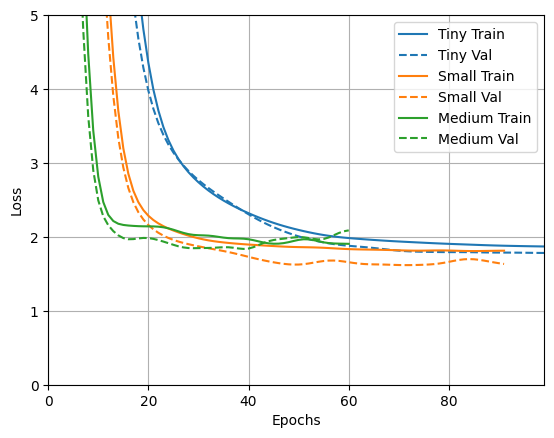

In [19]:
plotter.plot(size_histories)
plt.ylim([0, 5]);

### Large model

Finally, we create a large model with four hidden layers and 128 nodes in each layer. From our previous experience we would expect this is way too complex for the data set, however we will use this to investigate the effect of regularization.

In [20]:
large_model = Sequential()
large_model.add(normalizer)
large_model.add(Dense(128, activation="relu"))
large_model.add(Dense(128, activation="relu"))
large_model.add(Dense(128, activation="relu"))
large_model.add(Dense(128, activation="relu"))
large_model.add(Dense(1))

And, again, train the model using the same data:

In [21]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (None, 9)                   │              19 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)


Epoch: 0, loss:23.2924,  val_loss:22.1723,  
....................
Epoch: 20, loss:3.3580,  val_loss:4.1137,  
....................
Epoch: 40, loss:2.6778,  val_loss:2.4748,  
....................
Epoch: 60, loss:1.9539,  val_loss:2.0145,  
...........

Now, our large model performs significantly worse than the other models, with significant degradation of the validation loss.

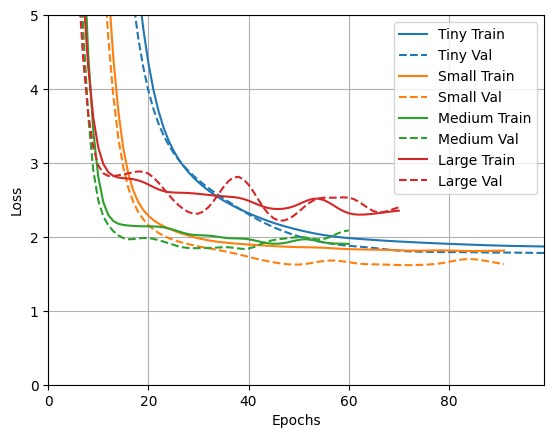

In [22]:
plotter.plot(size_histories)
plt.ylim([0,5]);

While building a larger model gives it more power, if this power is not constrained somehow it can easily overfit to the training set.

In this example, typically, only the tiny and small models manage to avoid overfitting altogether, and each of the larger models overfit the data more quickly. This become severe for the large model.

This is apparent if you plot and compare the validation metrics to the training metrics.

* It's normal for there to be a small difference.
* If both metrics are moving in the same direction, everything is fine.
* If the validation metric begins to stagnate while the training metric continues to improve, you are probably close to overfitting.
* If the validation metric is going in the wrong direction, the model is clearly overfitting.

Note: All the above training runs used the `callbacks.EarlyStopping` to end the training once it was clear the model was not making progress.

## Strategies to prevent overfitting

Before getting into the content of this section copy the training logs from the tiny model above, to use as a baseline for comparison.

In [23]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

### Add weight regularization


For machine learning models given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions. For models learned by neural networks: given some training data and a network architecture, there are multiple sets of weights values (multiple models) that could explain the data, and simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less variability (or a model with fewer parameters altogether, as demonstrated in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

* [L1 regularization](https://developers.google.com/machine-learning/glossary/#L1_regularization), where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights). This is also know as lasso regularization.

* [L2 regularization](https://developers.google.com/machine-learning/glossary/#L2_regularization), where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called ridge regularization or weight decay in the context of neural networks.

L1 regularization pushes weights towards exactly zero, encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights. This is one reason why L2 is more common.

In `tf.keras`, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. In the following we add L2 weight regularization to our large model.

In [24]:
l2_weight = .001
l2_model = Sequential()
l2_model.add(normalizer)
l2_model.add(Dense(128, activation="relu",kernel_regularizer=regularizers.l2(l2_weight)))
l2_model.add(Dense(128, activation="relu",kernel_regularizer=regularizers.l2(l2_weight)))
l2_model.add(Dense(128, activation="relu",kernel_regularizer=regularizers.l2(l2_weight)))
l2_model.add(Dense(128, activation="relu",kernel_regularizer=regularizers.l2(l2_weight)))
l2_model.add(Dense(1))

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (None, 9)                   │              19 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)


Epoch: 0, loss:23.9218,  val_loss:22.8885,  
....................
Epoch: 20, loss:3.1223,  val_loss:3.2536,  
....................
Epoch: 40, loss:3.3030,  val_loss:2.3547,  
....................
Epoch: 60, loss:2.2207,  val_loss:3.7788,  
..

`l2(0.001)` means that every coefficient in the weight matrix of the layer will add `0.001 * weight_coefficient_value**2` to the total **loss** of the network. This implementation works by adding the weight penalties to the model's loss, and then applying a standard optimization procedure after that.

So, the same `"large"` model with an `L2` regularization penalty performs better, although still not as well as the tiny model.


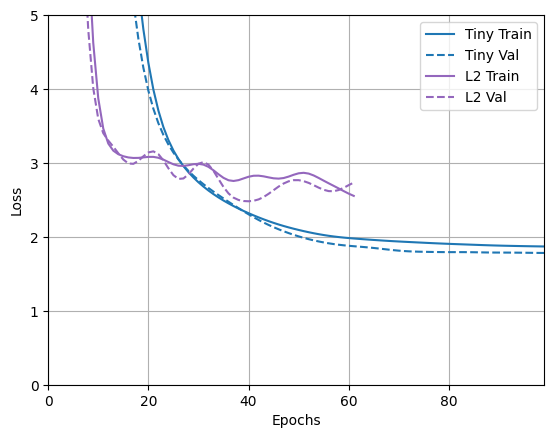

In [25]:
plotter.plot(regularizer_histories)
plt.ylim([0, 5]);

As demonstrated in the diagram above, the `"L2"` regularized model is now much more competitive with the `"tiny"` model. This `"L2"` model is also much more resistant to overfitting than the `"large"` model it was based on despite having the same number of parameters.

### Add dropout

Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by researchers at the University of Toronto.

The intuitive explanation for dropout is that because individual nodes in the network cannot rely on the output of the others, each node must output features that are useful on their own.

Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training. For example, a given layer would normally have returned a vector `[0.2, 0.5, 1.3, 0.8, 1.1]` for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. `[0, 0.5, 1.3, 0, 1.1]`.

The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

In Keras, you can introduce dropout in a network via the `tf.keras.layers.Dropout` layer, which gets applied to the output of layer right before.

Again we consider the large model, with a dropout after each hidden layer and with a dropout rate of 0.25. This means one-quarter of the weights are randomly set to zero.

In [26]:
dropout_rate = .25
dropout_model = Sequential()
dropout_model.add(normalizer)
dropout_model.add(Dense(128, activation="relu"))
dropout_model.add(Dropout(dropout_rate))
dropout_model.add(Dense(128, activation="relu"))
dropout_model.add(Dropout(dropout_rate))
dropout_model.add(Dense(128, activation="relu"))
dropout_model.add(Dropout(dropout_rate))
dropout_model.add(Dense(128, activation="relu"))
dropout_model.add(Dropout(dropout_rate))
dropout_model.add(Dense(1))

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (None, 9)                   │              19 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)


Epoch: 0, loss:23.4884,  val_loss:22.4393,  
....................
Epoch: 20, loss:3.9289,  val_loss:1.8860,  
...............

Now, we see much more consistent performance for the training and validation loss, which demonstrates that overfitting has been reduced. However, neither of these regularized large models performs as well as the the tiny model.

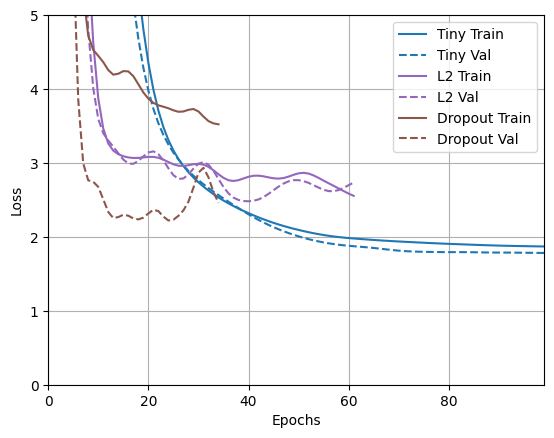

In [27]:
plotter.plot(regularizer_histories)
plt.ylim([0, 5]);

## Conclusions

To recap, here are the most common ways to prevent overfitting in neural networks:

* Get more training data.
* Reduce the capacity of the network.
* Add weight regularization.
* Add dropout.

Remember that each method can help on its own, but often combining them can be even more effective.

## Exercises

Create a large model (use the parameters for the large model above) which uses both L2 regularization and dropout. Experiment with values of these around `l2_weight = .001` and `dropout_rate = .25` to optimize the performance of your model. Plot the history of this optimal model against the tiny model and the other regularized models.

In [28]:
dropout_rate = .25
l2_weight = .0001
combined_model = Sequential()
combined_model.add(normalizer)
combined_model.add(Dense(128, activation="relu",kernel_regularizer=regularizers.l2(l2_weight)))
combined_model.add(Dropout(dropout_rate))
combined_model.add(Dense(128, activation="relu",kernel_regularizer=regularizers.l2(l2_weight)))
combined_model.add(Dropout(dropout_rate))
combined_model.add(Dense(128, activation="relu",kernel_regularizer=regularizers.l2(l2_weight)))
combined_model.add(Dropout(dropout_rate))
combined_model.add(Dense(128, activation="relu",kernel_regularizer=regularizers.l2(l2_weight)))
combined_model.add(Dropout(dropout_rate))
combined_model.add(Dense(1))

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (None, 9)                   │              19 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)


Epoch: 0, loss:23.5791,  val_loss:22.5420,  
....................
Epoch: 20, loss:4.1494,  val_loss:2.0160,  
....................
Epoch: 40, loss:3.5860,  val_loss:1.8845,  
....................
Epoch: 60, loss:3.1364,  val_loss:2.0450,  
................

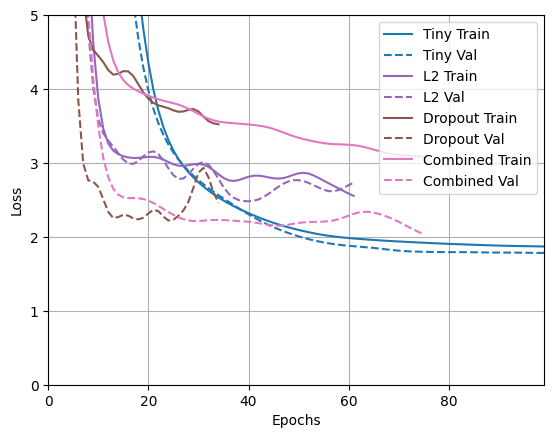

In [29]:
plotter.plot(regularizer_histories)
plt.ylim([0, 5]);